In [ ]:
import zipfile
import os
from tqdm import tqdm
import cv2
import configparser
import numpy as np

# Скачивание данных

Изначально предполагалось также использование данных со спортивных мероприятий (SoccerNet, SportsMOT и др.). Однако в ходе первоначального просмотра этих датасетов, было обнаружено, что размечены исключительно спортсмены и игроки, а зрители, которые в целом имеют такие же паттерны для детекции в разметку не попали. Для данного проекта считаю основопологающим детекцию и трекинг человеческого трафика в совокупности, а не только спортсменов. Поэтому в проекте будет использован исключительно датасет MOT разных годов выпуска

## MOT

### MOT-20

In [8]:
!mkdir -p data/MOT/MOT_20 && cd data/MOT/MOT_20 && wget https://motchallenge.net/data/MOT20.zip

--2025-11-16 18:56:13--  https://motchallenge.net/data/MOT20.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5028926248 (4,7G) [application/zip]
Saving to: ‘MOT20.zip’

MOT20.zip           100%[===================>]   4,68G  7,91MB/s    in 10m 47s 

2025-11-16 19:07:01 (7,41 MB/s) - ‘MOT20.zip’ saved [5028926248/5028926248]



### MOT-17

In [9]:
!mkdir -p data/MOT/MOT_17 && cd data/MOT/MOT_17 && wget https://motchallenge.net/data/MOT17.zip

--2025-11-16 19:08:42--  https://motchallenge.net/data/MOT17.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5860214001 (5,5G) [application/zip]
Saving to: ‘MOT17.zip’

MOT17.zip           100%[===================>]   5,46G  7,47MB/s    in 13m 54s 

2025-11-16 19:22:36 (6,70 MB/s) - ‘MOT17.zip’ saved [5860214001/5860214001]



### MOT-16

In [11]:
!mkdir -p data/MOT/MOT_16 && cd data/MOT/MOT_16 && wget https://motchallenge.net/data/MOT16.zip

--2025-11-16 19:25:48--  https://motchallenge.net/data/MOT16.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1954509127 (1,8G) [application/zip]
Saving to: ‘MOT16.zip’

MOT16.zip           100%[===================>]   1,82G  8,63MB/s    in 3m 50s  

2025-11-16 19:29:38 (8,11 MB/s) - ‘MOT16.zip’ saved [1954509127/1954509127]



### MOT-15

In [12]:
!mkdir -p data/MOT/MOT_15 && cd data/MOT/MOT_15 && wget https://motchallenge.net/data/MOT15.zip

--2025-11-16 19:29:39--  https://motchallenge.net/data/MOT15.zip
Resolving motchallenge.net (motchallenge.net)... 131.159.19.34, 2a09:80c0:18::1034
Connecting to motchallenge.net (motchallenge.net)|131.159.19.34|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1310994213 (1,2G) [application/zip]
Saving to: ‘MOT15.zip’

MOT15.zip           100%[===================>]   1,22G  16,1MB/s    in 3m 42s  

2025-11-16 19:33:21 (5,64 MB/s) - ‘MOT15.zip’ saved [1310994213/1310994213]



# Распаковка данных

In [ ]:
data_dir = "data/MOT"
dest_path = 'data/MOT/unpacked_data'

for ds_name in tqdm(os.listdir(data_dir)):
    ds_path = os.path.join(data_dir, ds_name)
    if not os.path.isdir(ds_path):
        continue

    for zip_name in os.listdir(ds_path):
        zip_path = os.path.join(ds_path, zip_name)

        if not zip_path.lower().endswith(".zip"):
            continue

        extract_dir = os.path.join(dest_path, ds_name)

        with zipfile.ZipFile(zip_path, 'r') as zf:
            zf.extractall(extract_dir)

100%|██████████| 9/9 [00:49<00:00,  5.54s/it]


# Преобразование формата данных

Для фильтрации неинформативных картинок бует использоваться YOLO в решении ultralytics, как SOTA модель с очень удобной реализацией. Поэтому приведем данные к формату YOLO. Будем использовать разрешение изображения 1280х720

In [ ]:
def create_txt(path_to_txt, path_to_save_folder, sizes):
    img_W, img_H = sizes
    save_dict = {}
    img_prefix = path_to_txt.split('/')[-3]
    task = path_to_txt.split('/')[-4]
    with open(path_to_txt) as f:
        for line in f:
            data = line.strip().split(',')
            if len(data) == 10 and task == 'test':
                img_id, _, x, y, w, h, _, _, _, _ = data
            elif len(data) == 7 and task == 'test':
                img_id, _, x, y, w, h, _ = data
            elif len(data) == 9 and task == 'train':
                img_id, _, x, y, w, h, _, _, _ = data
            elif len(data) == 10 and task == 'train':
                img_id, _, x, y, w, h, _, _, _, _ = data
            else:
                print(path_to_txt)
            img_id = '000000'[:-(len(str(img_id)))] + str(img_id)
            img_id = f"{img_prefix}_{img_id}"
            w = float(w)
            h = float(h)
            x_c = float(x) + w / 2
            y_c = float(y) + h / 2
            if img_id not in save_dict:
                save_dict[img_id] = [[0, x_c / img_W, y_c / img_H, w / img_W, h / img_H]]
            else:
                save_dict[img_id].append([0, x_c / img_W, y_c / img_H, w / img_W, h / img_H])

    for img_id in save_dict:
        save_path = f"{path_to_save_folder}/{img_id}.txt"
        with open(save_path, 'w') as f:
            for bbox in save_dict[img_id]:
                print(*bbox, file=f)

def get_img_sizes(path):
    config = configparser.ConfigParser()
    config.read(path)
    W = config['Sequence']['imWidth']
    H = config['Sequence']['imHeight']
    return (int(W), int(H))

def create_YOLO_format(source, dest_path, task, sizes=(1280, 720)):
    dss = os.listdir(source)
    for ds in tqdm(dss):
        ds_path = os.path.join(source, ds, task)
        folders = os.listdir(ds_path)
        for folder in folders:
            bboxes_txt_path = os.path.join(source, ds, task, folder, 'det/det.txt' if task == 'test' else 'gt/gt.txt')
            dest_labels_path = os.path.join(dest_path, f'{task}/labels')
            seqinfo_path = os.path.join(source, ds, task, folder, 'seqinfo.ini')
            create_txt(bboxes_txt_path, dest_labels_path, sizes=get_img_sizes(seqinfo_path))

            # работа с картинками
            imgs_path = os.path.join(source, ds, task, folder, 'img1')
            imgs_names = os.listdir(imgs_path)
            for img_name in imgs_names:
                orig_img_path = os.path.join(imgs_path, img_name)
                dest_img_path = os.path.join(dest_path, f'{task}/images', f"{folder}_{img_name}")
                img = cv2.imread(orig_img_path)
                res_img = cv2.resize(img, sizes)
                cv2.imwrite(dest_img_path, res_img)

In [129]:
source = 'data/unpacked_data'
dest_path = 'data/YOLO'
tasks = ['train', 'test']

for task in tasks:
    dest_path_task = os.path.join(dest_path, task)
    for folder in ['images', 'labels']:
        dest_path_folder = os.path.join(dest_path_task, folder)
        if not os.path.isdir(dest_path_folder):
            os.makedirs(dest_path_folder)

create_YOLO_format(source, dest_path, 'train')
create_YOLO_format(source, dest_path, 'test')

100%|██████████| 4/4 [00:04<00:00,  1.00s/it]


## Посмотрим на данные

data/YOLO/train/labels/MOT16-05_000094.txt
data/YOLO/train/labels/MOT20-02_000284.txt
data/YOLO/train/labels/ETH-Pedcross2_000277.txt
data/YOLO/train/labels/MOT17-09-DPM_000404.txt
data/YOLO/train/labels/MOT17-13-FRCNN_000711.txt
data/YOLO/train/labels/MOT17-13-SDP_000075.txt
data/YOLO/train/labels/ETH-Bahnhof_000265.txt
data/YOLO/train/labels/MOT16-11_000776.txt
data/YOLO/train/labels/MOT17-04-FRCNN_000858.txt
data/YOLO/train/labels/MOT20-02_000030.txt
data/YOLO/train/labels/MOT20-03_000582.txt
data/YOLO/train/labels/MOT17-11-SDP_000559.txt
data/YOLO/train/labels/ADL-Rundle-6_000100.txt
data/YOLO/train/labels/MOT16-13_000274.txt
data/YOLO/train/labels/KITTI-17_000075.txt
data/YOLO/train/labels/MOT16-02_000146.txt


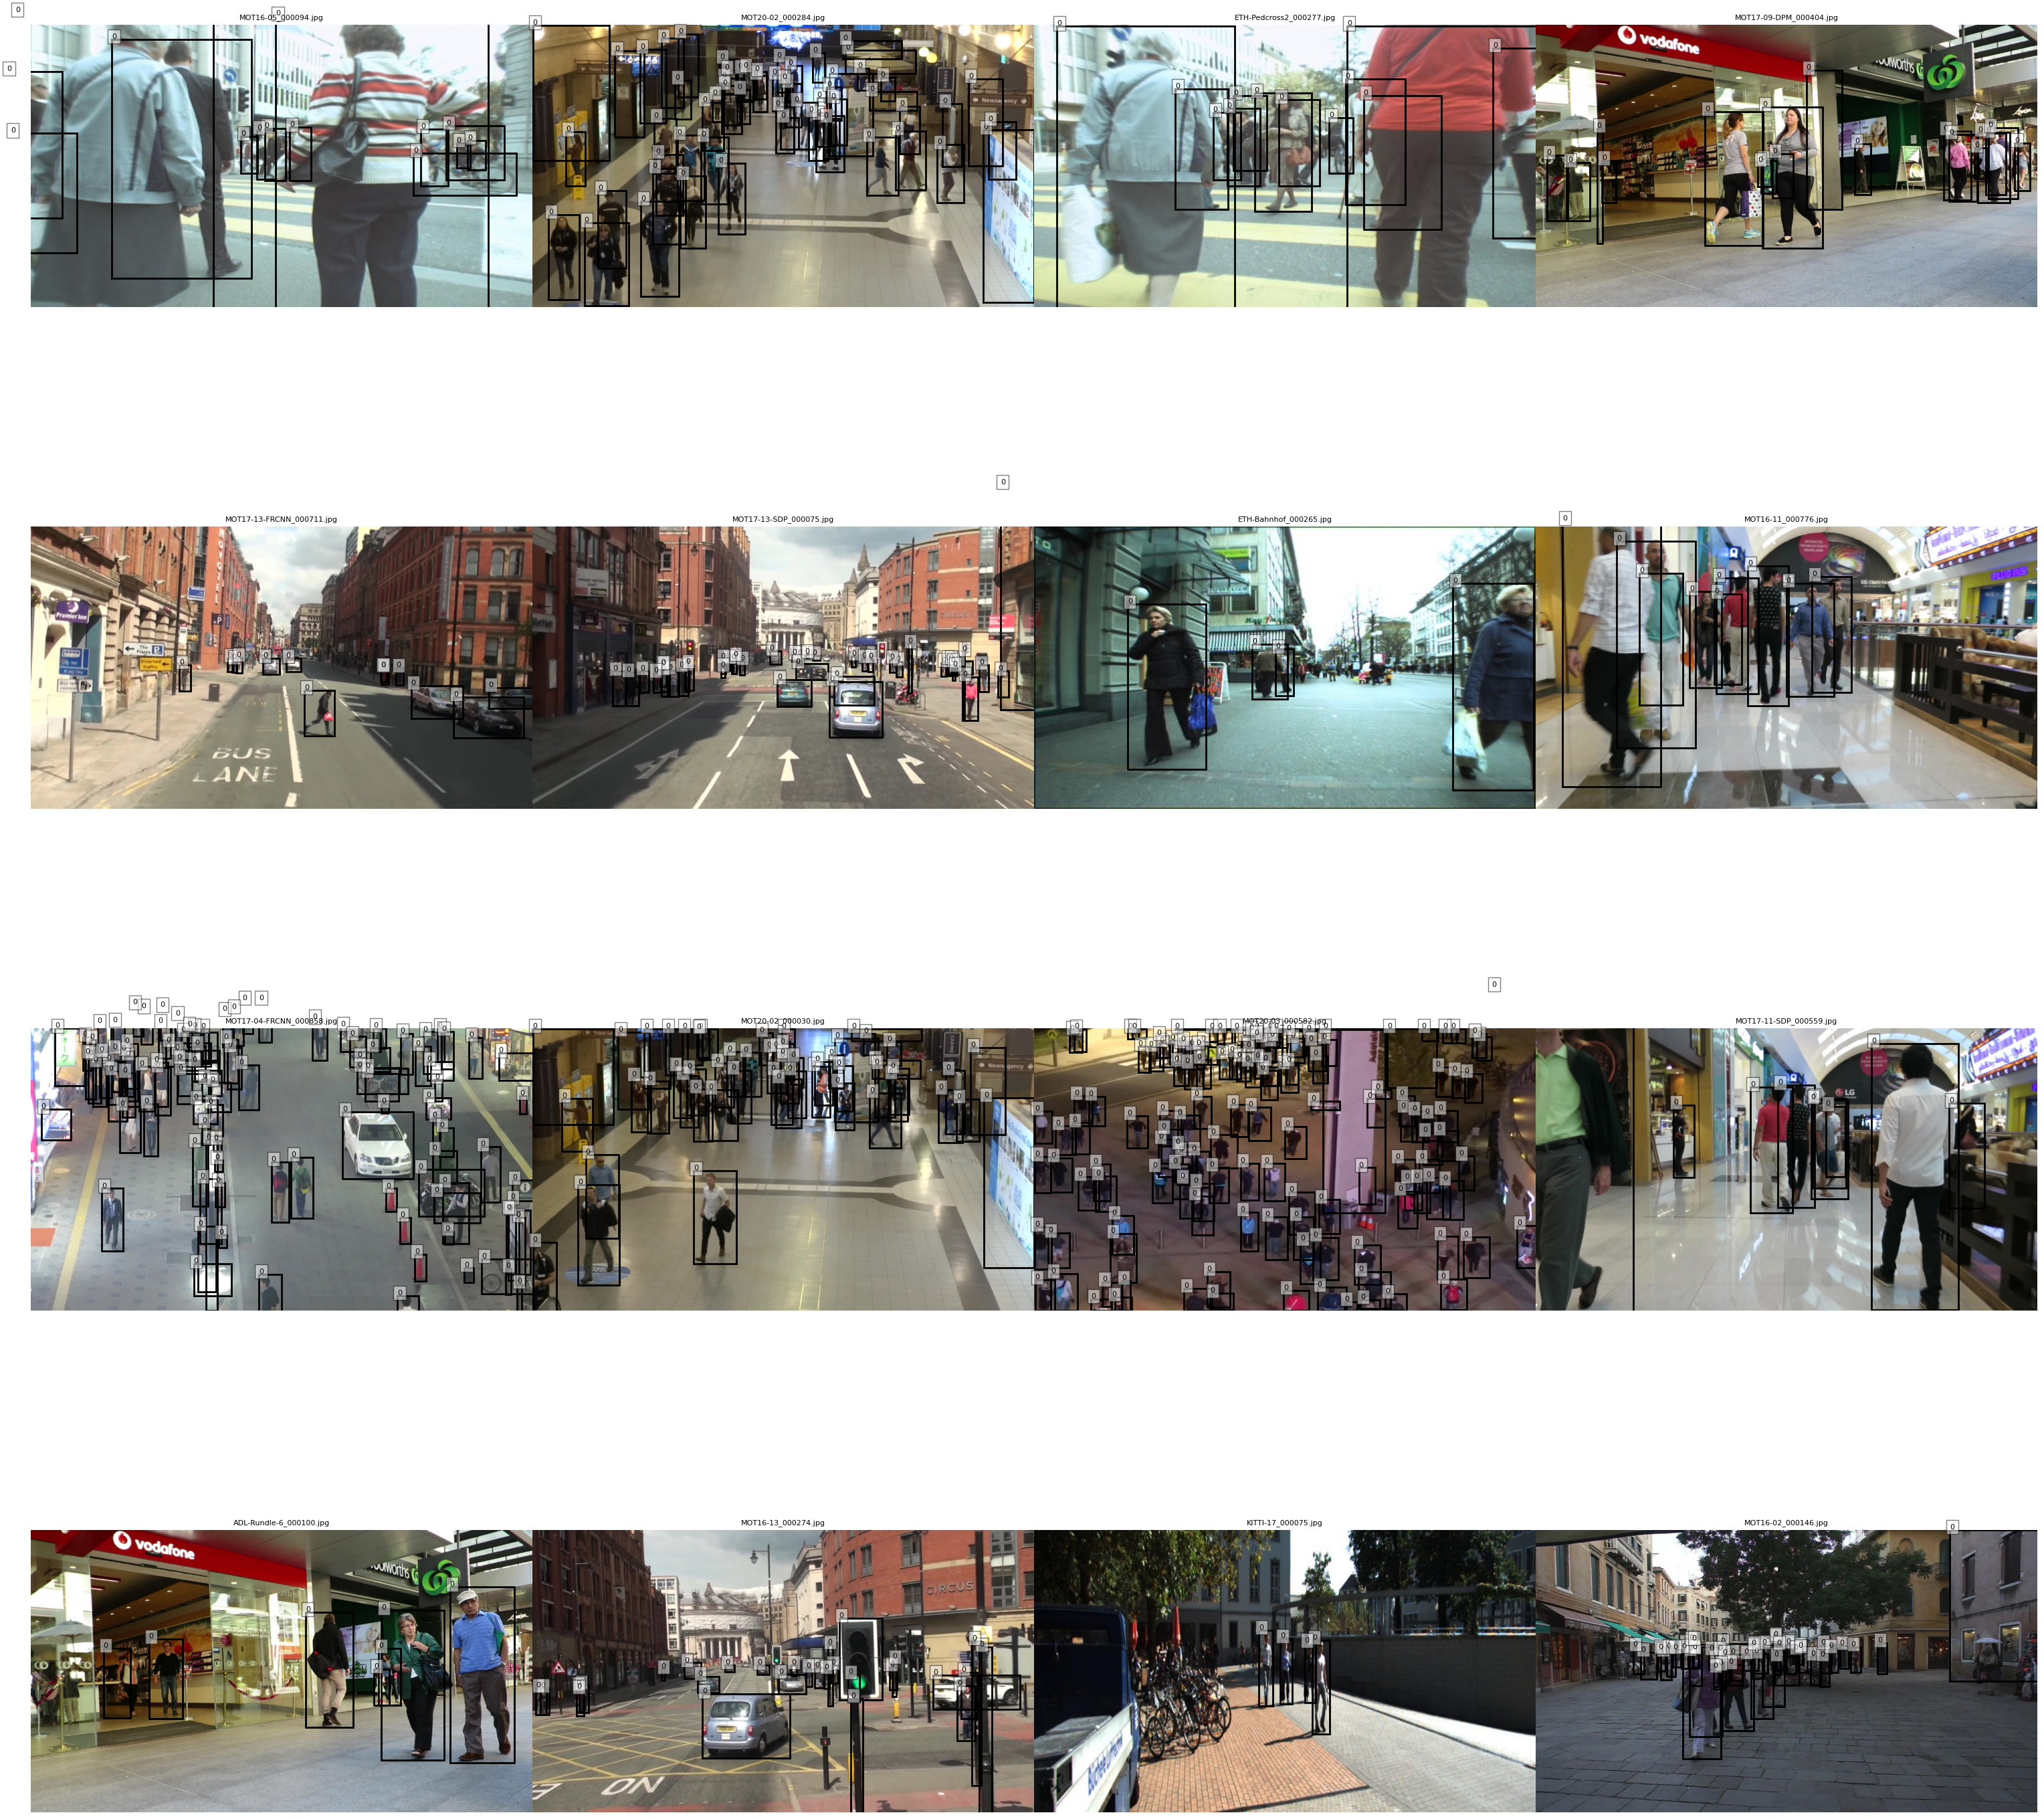

In [130]:
path = 'data/YOLO/train'

imgs_path = os.path.join(path, 'images')
label_path = os.path.join(path, 'labels')

img_names = os.listdir(imgs_path)
img_names = np.random.choice(img_names, replace=False, size=16)

fig, axes = plt.subplots(4, 4, figsize=(30, 30))
axes = axes.flatten()

for ax, img_name in zip(axes, img_names):
    img_path = os.path.join(imgs_path, img_name)
    img = cv2.imread(img_path)

    if img is None:
        ax.axis('off')
        continue

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    txt_name = f"{os.path.splitext(img_name)[0]}.txt"
    txt_path = os.path.join(label_path, txt_name)
    print(txt_path)

    ax.imshow(img)

    if os.path.exists(txt_path):
        with open(txt_path, 'r') as f:
            for line in f:
                parts = line.strip().split()

                cls, x_c_n, y_c_n, w_n, h_n = parts
                x_c_n = float(x_c_n)
                y_c_n = float(y_c_n)
                w_n = float(w_n)
                h_n = float(h_n)

                x_c = x_c_n * w
                y_c = y_c_n * h
                bw = w_n * w
                bh = h_n * h

                x1 = x_c - bw / 2
                y1 = y_c - bh / 2
                rect = plt.Rectangle(
                    (x1, y1), bw, bh,
                    fill=False, linewidth=2
                )
                ax.add_patch(rect)

                ax.text(
                    x1, y1 - 2,
                    str(cls),
                    fontsize=8,
                    bbox=dict(facecolor='white', alpha=0.5)
                )

    ax.set_title(img_name, fontsize=8)
    ax.axis('off')

for i in range(len(img_names), len(axes)):
    axes[i].axis('off')

plt.tight_layout()

plt.subplots_adjust(left=0, right=1, top=1, bottom=0,
                    wspace=0, hspace=0)
plt.show()
